# Delhi AQI Prediction

## Import dependencies

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from helpers.constants import (
    CATEGORICAL_COLS,
    DROP_COLS,
    RANDOM_STATE,
    TARGET_COL,
    TEST_SIZE,
)
from helpers.datetimetransformer import datetime_to_unix
from helpers.mutualinformationselector import find_relevant_features
from gradientdescent.linearegression import LinearRegression
from gradientdescent.forwardpass import predict
from gradientdescent.lossfunction import compute_rmse_loss
from animation.animate import plot_contour

## Import Data

In [2]:
df = pd.read_csv("./data/delhi_ncr_aqi_dataset.csv")

## Do required preprocessing

In [3]:
df = df.drop(columns=DROP_COLS)
df["datetime"] = datetime_to_unix(df["datetime"])

## Label data

In [4]:
X = df.drop(columns=[TARGET_COL])
y = df[TARGET_COL]

## Split data into train test split

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, shuffle=True
)

## Find relevant features among all features

In [6]:
releveant_features = find_relevant_features(X_train, y_train)
print("Relevant features:")
print(releveant_features)

MI Results:
pm25           3.730514
pm10           3.434608
no2            1.504895
co             1.501679
so2            1.259781
datetime       1.225785
visibility     1.085297
season         0.918263
humidity       0.647804
o3             0.621812
temperature    0.581690
wind_speed     0.370204
longitude      0.017398
latitude       0.014485
is_weekend     0.005888
day_of_week    0.004565
dtype: float64
Relevant features:
['pm25', 'pm10', 'no2', 'co', 'so2', 'datetime', 'visibility', 'season', 'humidity', 'o3', 'temperature', 'wind_speed', 'longitude', 'latitude']


## Dividing features into categorical and numerical and applying different transformations on the features

In [7]:
selected_categorical = [col for col in releveant_features if col in CATEGORICAL_COLS]
selected_numerical = [col for col in releveant_features if col not in CATEGORICAL_COLS]

## Defining preprocessor pipeline

In [8]:
preprocessor = ColumnTransformer(
    transformers=[
        (
            "num",
            StandardScaler(),
            selected_numerical,
        ),
        (
            "cat",
            OneHotEncoder(drop="first", handle_unknown="ignore", sparse_output=False),
            selected_categorical,
        ),
    ],
    remainder="drop",
)

## Applying transformations to features and reshaping labels

In [9]:
X_train_final = preprocessor.fit_transform(X_train)
X_test_final = preprocessor.transform(X_test)
y_train_np = y_train.to_numpy(dtype=np.float64).reshape(-1, 1)
y_test_np = y_test.to_numpy(dtype=np.float64).reshape(-1, 1)

## Checking vector dimensions after applying all transformations

In [10]:
print("Preprocessing completed.")
print("X_train shape:", X_train_final.shape)
print("X_test shape:", X_test_final.shape)
print("y_train shape:", y_train_np.shape)
print("y_test shape:", y_test_np.shape)

Preprocessing completed.
X_train shape: (141164, 16)
X_test shape: (60500, 16)
y_train shape: (141164, 1)
y_test shape: (60500, 1)


## Printing list of final feature names

In [11]:
final_feature_names = preprocessor.get_feature_names_out()
print(final_feature_names)

['num__pm25' 'num__pm10' 'num__no2' 'num__co' 'num__so2' 'num__datetime'
 'num__visibility' 'num__humidity' 'num__o3' 'num__temperature'
 'num__wind_speed' 'num__longitude' 'num__latitude'
 'cat__season_post_monsoon' 'cat__season_summer' 'cat__season_winter']


## Linear Regression With Constant Learning Rate

### Running the Algorithm

In [12]:
linear_regression = LinearRegression(X_train_final,y_train_np,learning_rate=0.05,n_iters=2000)
weights_final, bias_final, w_history, b_history = linear_regression.train_const_lr()

Iteration 0, MSE: 315.9111
Iteration 100, MSE: 45.0268
Iteration 200, MSE: 42.8459
Iteration 300, MSE: 42.1661
Iteration 400, MSE: 41.8154
Iteration 500, MSE: 41.5592
Iteration 600, MSE: 41.3457
Iteration 700, MSE: 41.1608
Iteration 800, MSE: 40.9986
Iteration 900, MSE: 40.8558
Iteration 1000, MSE: 40.7298
Iteration 1100, MSE: 40.6186
Iteration 1200, MSE: 40.5205
Iteration 1300, MSE: 40.4339
Iteration 1400, MSE: 40.3575
Iteration 1500, MSE: 40.2900
Iteration 1600, MSE: 40.2304
Iteration 1700, MSE: 40.1779
Iteration 1800, MSE: 40.1315
Iteration 1900, MSE: 40.0905


### Plotting the path taken by the algorithm

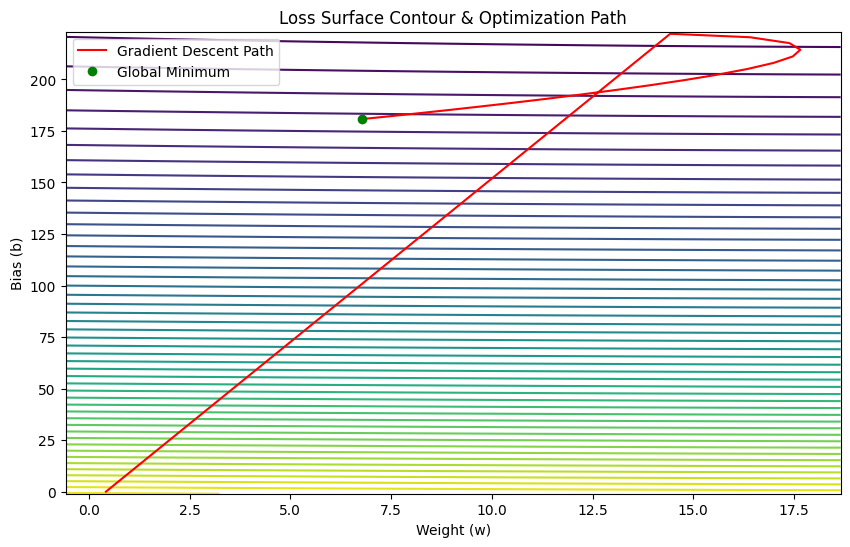

In [13]:
plot_contour(X_train_final,y_train_np,w_history,b_history)

### Predicting test values depending on the training

In [14]:
y_test_pred = predict(X_test_final,weights_final,bias_final)

### Printing Output

In [15]:
data = {"original":y_test,"predicted":y_test_pred.flatten()}
pred_data = pd.DataFrame(data)
print("difference: ", compute_rmse_loss(y_test_np,y_test_pred))
pred_data

difference:  40.04053635843199


,original,predicted
66123,430,437.319527
162132,500,448.961069
78992,129,164.176753
185233,72,8.703466
94786,500,539.869624
...,...,...
106709,215,180.141420
173127,356,413.250180
8197,254,206.745536
42260,150,191.312545


## Linear Regression with exponentially decaying Learning Rate

In [16]:
linear_regression = LinearRegression(X_train_final,y_train_np,learning_rate=0.1,n_iters=2000)
weights_final, bias_final, w_history, b_history = linear_regression.train_decreasing_lr()

Iteration 0, MSE: 315.2401, learning rate: 0.1000
Iteration 100, MSE: 43.4262, learning rate: 0.0610
Iteration 200, MSE: 42.4125, learning rate: 0.0370
Iteration 300, MSE: 42.1206, learning rate: 0.0224
Iteration 400, MSE: 41.9873, learning rate: 0.0136
Iteration 500, MSE: 41.9161, learning rate: 0.0082
Iteration 600, MSE: 41.8755, learning rate: 0.0050
Iteration 700, MSE: 41.8517, learning rate: 0.0030
Iteration 800, MSE: 41.8376, learning rate: 0.0018
Iteration 900, MSE: 41.8291, learning rate: 0.0011
Iteration 1000, MSE: 41.8240, learning rate: 0.0007
Iteration 1100, MSE: 41.8209, learning rate: 0.0004
Iteration 1200, MSE: 41.8190, learning rate: 0.0002
Iteration 1300, MSE: 41.8179, learning rate: 0.0002
Iteration 1400, MSE: 41.8172, learning rate: 0.0001
Iteration 1500, MSE: 41.8168, learning rate: 0.0001
Iteration 1600, MSE: 41.8165, learning rate: 0.0000
Iteration 1700, MSE: 41.8164, learning rate: 0.0000
Iteration 1800, MSE: 41.8163, learning rate: 0.0000
Iteration 1900, MSE: 41

### Plotting the path taken by the algorithm

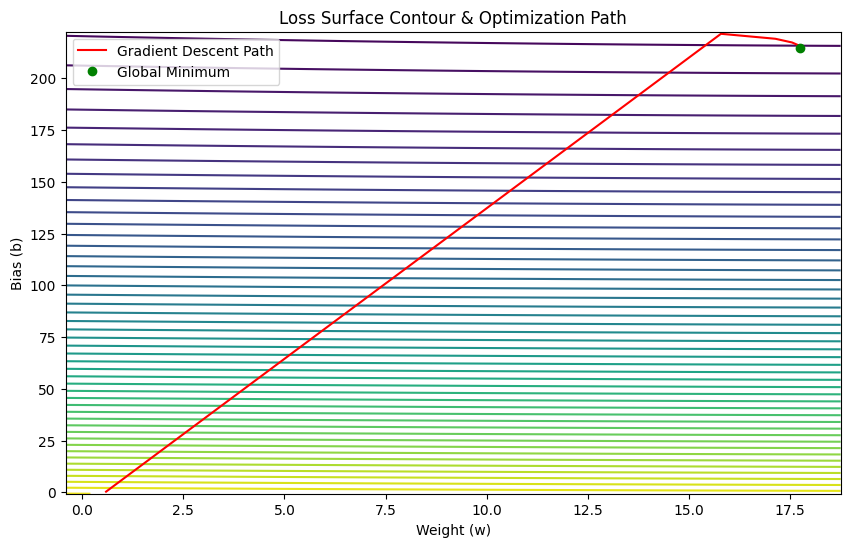

In [17]:
plot_contour(X_train_final,y_train_np,w_history,b_history)

### Predicting test values depending on the training

In [18]:
y_test_pred = predict(X_test_final,weights_final,bias_final)

### Printing Output

In [19]:
data = {"original":y_test,"predicted":y_test_pred.flatten()}
pred_data = pd.DataFrame(data)
print("difference: ", compute_rmse_loss(y_test_np,y_test_pred))
pred_data

difference:  41.818227998815345


,original,predicted
66123,430,444.059224
162132,500,445.284470
78992,129,149.687048
185233,72,2.634583
94786,500,542.672223
...,...,...
106709,215,187.541790
173127,356,413.077158
8197,254,219.407589
42260,150,180.161197
